# Final project: Playlist Classification

This it the report of our project 'Playlist Classification', the authors are:
- Gianluca Procopio, 1942103;  
- Andrea Polidori, 2143429;  
- Giuliana Prinzi, 1952137;
- Laura Concari, 1890490;  
- Erika Ioana Zetu, 1888659.  

In this notebook you can find initially the data collecting, the pre-processing and the data exploration. Later, there are two sections (Supervised and Unsupervised models) where we will illustrate and explain which model we used and what can we deduct from each one.

**ATTENTION**   
I will strongly suggest to not run the data collecting and the data pre-processing because it's been a complex process we did on our local machines that required a lot of works, we posted the code just to illustrate what we did but we uploaded only the sets already clean and ready to being used. In particular, the data collecting won't work because I didn't upload my personal API's key so it won't work; moreover, the code would take many minutes to collect all the songs.  You can run starting from 'Taking a look to the data' section, right below the pre-processing.

## Import

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.model_selection import GridSearchCV
import warnings
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import spotipy.exceptions
import csv
from config import CLIENT_ID, CLIENT_SECRET, REDIRECT_URI
from collections import defaultdict

We got some FutureWarning among the notebook and we blocked them in order to keep the notebook clean and tidy.

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### Role of each member

After we decided this project, I, Gianluca, worked on the data collecting and later started the data pre-processing with the helps of the others.  

When it cames to test different models, I took care of the KNN and of the K-Means, while the other trained the Random Forest and Decision Tree models and took care of the presentations.

## Preprocessing

### Collecting data

In order to collect data, we took advantage of the Spotipy API for Devoleper called _Spotipy_. We signed in Spotify for Developers and we used the credentials we got there (CLIENT_ID and CLIENT_SECRET) in order to connect to Spotify. Then, we selected some plsylists - a few for each fo us - and for each playlist we extracted all the songs and thei features, this could be easily done with the audio_features(..) method - available in spotipy.

To each playlist was assigned a tag (one of our names) as suggested from the teacher and the TAs, such that later we will be able to assign a label to each song, making this a supervised learning problem.

In [ ]:
scope = 'playlist-read-private'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id='CLIENT_ID', client_secret='CLIENT_SECRET', redirect_uri=REDIRECT_URI, scope=scope))

# copy the url and extract the id, which is on the right of '/'
# i need a list of playlist's ids
raggae = [('5TBKHHPYImlo3JFvmlnfAC','Gianluca'),('03sDEv7FN58Mb9CJOs1Tgn','Gianluca'),('4X1UqwchhBFITHBLT9tkNJ','Gianluca'),('5m9CzTLsTQ9eZi2FycUpIo','Gianluca'),('3gHH9sIe79r7Y082jIV1Cu','Gianluca'),('37i9dQZF1DXco4ODkIraMD','Gianluca')] 
classic = [('1kGtBpJnR0bPWX4JXi5wUo','Laura'),('2JV0xEGVwIKCuFo5EbAica','Laura'),('37i9dQZF1EIcUYESbdArbm','Laura'),('37i9dQZF1DWWEJlAGA9gs0','Laura'),('37i9dQZF1DWVFeEut75IAL','Laura'),('37i9dQZF1DWSMJ6QxunHcJ','Laura')]
hiphop = [('37i9dQZF1EQnqst5TRi17F','Giuliana'),('5DZ93TH6ABgWYRgdBNJs8O','Giuliana'),('37i9dQZF1DX186v583rmzp','Giuliana'),('37i9dQZF1DX48TTZL62Yht','Giuliana'),('37i9dQZF1DXbkfWVLd8wE3','Giuliana'),('3OrM2V0EsEeJf10WqqA8NP','Giuliana'),('4Re8POjxevmWFk8fcT71sU','Giuliana')]
techno = [('37i9dQZF1DWTiY3QffFUdg','Andrea'),('01aBVibTe6ia4BbCFQm4iD','Andrea'),('5Eec5PtiELmFRBsNgjyA0v','Andrea'),('1doRrkfcLJKhSb3agBqCch','Andrea'),('2oC9jBlyBkV5DZZC4TNXWB','Andrea'),('5Kb9Xeuzni24ZWL4XuE7RI','Andrea'),('0Ijh3qcWYkfBYnwWDC9kxQ','Andrea')]
rock = [('37i9dQZF1EQpj7X7UK8OOF','Erika'),('37i9dQZF1DWZNFWEuVbQpD','Erika'),('4t8cpLBAeXiT4MXyS7SbV6','Erika'),('37i9dQZF1DWXRqgorJj26U','Erika'),('4jOqGKvV7iu0ojea2pt9Te','Erika'),('37i9dQZF1DX6rsDrBNGuWW','Erika'),('37i9dQZF1DWWsq4e0rDzty','Erika')]
uris = raggae + classic + hiphop + techno + rock

# create a dict such that for each user there is a set of genres extraced from the rispective column
user_genres = defaultdict(set)

with open('data/our_songs.csv', 'w', newline='', encoding='utf-8') as songs:

    for pl,tag in uris:
        uri = 'spotify:playlist:' + pl
        results = sp.playlist_tracks(uri)
        features = sp.audio_features([results['items'][0]['track']['id']])[0]
        # # list of columns names
        columns = ['Track','Artist','Tag']
        columns = columns + list(features.keys())
        # write on the csv
        writer = csv.DictWriter(songs,fieldnames=columns)
        writer.writeheader()
        for item in results['items']:
            track = item['track']
            audio_features = sp.audio_features([track['id']])[0]
            audio_features['Track'] = track['name']
            audio_features['Artist'] = track['artists'][0]['name']
            audio_features['Tag'] = tag

            writer.writerow(audio_features)

### Pre-processing Train Set

By looking at the first rows of the our handmade trainset we can see that some of the column are not normalized, so we have to do it:

In [28]:
train = pd.read_csv('data/our_songs.csv')
train.head()

,Track,Artist,Tag,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Yo Voy (feat. Daddy Yankee),Zion & Lennox,Gianluca,0.808,0.697,10,-5.899,1,0.2410,0.041,...,0.0546,0.554,95.060,audio_features,5gflgO9EPbIBf16n5TKnQS,spotify:track:5gflgO9EPbIBf16n5TKnQS,https://api.spotify.com/v1/tracks/5gflgO9EPbIB...,https://api.spotify.com/v1/audio-analysis/5gfl...,232020,4
1,Gasolina,Daddy Yankee,Gianluca,0.852,0.797,0,-6.543,1,0.0614,0.322,...,0.0845,0.741,96.008,audio_features,228BxWXUYQPJrJYHDLOHkj,spotify:track:228BxWXUYQPJrJYHDLOHkj,https://api.spotify.com/v1/tracks/228BxWXUYQPJ...,https://api.spotify.com/v1/audio-analysis/228B...,192600,4
2,PAPI (feat. Babywine & Alberto Stylee),DJ Nelson,Gianluca,0.909,0.716,1,-6.628,1,0.1260,0.359,...,0.1060,0.417,105.078,audio_features,2wQBzAZdsaqDBbtwBk5MhA,spotify:track:2wQBzAZdsaqDBbtwBk5MhA,https://api.spotify.com/v1/tracks/2wQBzAZdsaqD...,https://api.spotify.com/v1/audio-analysis/2wQB...,187093,4
3,Envolver,Anitta,Gianluca,0.812,0.736,4,-5.421,0,0.0833,0.152,...,0.0914,0.396,91.993,audio_features,3IAfUEeaXRX9s9UdKOJrFI,spotify:track:3IAfUEeaXRX9s9UdKOJrFI,https://api.spotify.com/v1/tracks/3IAfUEeaXRX9...,https://api.spotify.com/v1/audio-analysis/3IAf...,193806,4
4,Te Boté,Darell,Gianluca,0.918,0.602,4,-3.986,0,0.1150,0.401,...,0.0805,0.158,96.518,audio_features,42FWqCxAw5aG1FvjyVjIlH,spotify:track:42FWqCxAw5aG1FvjyVjIlH,https://api.spotify.com/v1/tracks/42FWqCxAw5aG...,https://api.spotify.com/v1/audio-analysis/42FW...,275693,4


Here we normalize some columns and drop the useless features such that we will have the same feature as the ones we found on the Kaggle dataset (more later).

In [ ]:
def min_max_scaling(column):
    if column.min() < 0 or column.max() > 1:
        return (column - column.min()) / (column.max() - column.min())
    else:
        return column

train = pd.read_csv('data/our_songs.csv')
train = train.drop_duplicates()
train = train.dropna()
# normalize columns
to_normalize = ['danceability', 'energy', 'speechiness','acousticness','instrumentalness','liveness','valence']
train[to_normalize] = train[to_normalize].apply(min_max_scaling, axis=0)

train = train.drop(columns=['type','id','uri','track_href','analysis_url','duration_ms'])
train = train.reset_index(drop=True)

### Pre-processing Test Set

Since we have added the labels in the Train Set, we had to figure out how could we had these labels to each song in the test set. Hence, we took a look to our train set and for each tag we looked for some keywords in the genre column that could help us classify each song. 

In the next lines we analyzed the music genres column and we added the right label when we found a certain keyword.

In [ ]:
### preprocessing of test set
test = pd.read_excel('/Users/gianluca/Desktop/magistrale/primo anno/Primo semestre/Fundamentals of Data Science/Project/data/songs_df.xlsx')
test = test[['track_name','artists_names','artist_genres','acousticness',
             'danceability','energy','instrumentalness','key','liveness',
             'loudness','mode','speechiness','tempo','time_signature','valence']]
test = test.dropna()

# split the genres such that it becomes a list of strings
test['artist_genres'] = test['artist_genres'].str.split(';')

def categorize_genre(genre):
    rock_keywords = ['rock']
    hip_hop_keywords = ['rap', 'hip hop']
    classic_keywords = ['classical', 'orchestra', 'opera', 'symphony']
    techno_keywords = ['techno', 'electronic', 'house']
    reggaeton_keywords = ['reggaeton', 'dembow', 'latin', 'perreo','spanish','raggae']
    genre_lower = [g.lower() for g in genre]

    if any(keyword in genre_lower for keyword in rock_keywords):
        return 'Erika'
    elif any(keyword in genre_lower for keyword in hip_hop_keywords):
        return 'Giuliana'
    elif any(keyword in genre_lower for keyword in classic_keywords):
        return 'Laura'
    elif any(keyword in genre_lower for keyword in techno_keywords):
        return 'Andrea'
    elif any(keyword in genre_lower for keyword in reggaeton_keywords):
        return 'Gianluca'
    else:
        return 'other'
    
test['Tag'] = test['artist_genres'].apply(categorize_genre)
# drop the useless columns and rows
test = test[test['Tag'] != 'other']
test = test.drop(columns=['artist_genres'])
test = test.reset_index(drop=True)

# fix the artist name such that will appear only the first artist
test['artists_names'] = test['artists_names'].str.split(';').apply(lambda x: x[0])

Then, we checked if there were any rows in common, and we dropped them.

In [ ]:
## clean test: check if there are any rows in common
merge = pd.merge(train[['Track', 'Artist']], 
                 test[['track_name', 'artists_names']], 
                 how='left', left_on=['Track', 'Artist'], 
                 right_on=['track_name', 'artists_names'])
merge = merge[merge['Track'].isna()]
merge = merge.drop(['Track', 'Artist'], axis=1)

In the end we changed some columns names in the test set and changed the order of the features in the train set such that they will be in the same order as the columns in the test set and later we saved the sets on two local .csv files.

In [ ]:
clmn_names = {
    'track_name': 'Track', 
    'artists_names': 'Artist'
    }
test.rename(columns=clmn_names, inplace=True)

# reorder the train set columns such that they'll be in the same order as the test set
train = train[['Track', 'Artist','acousticness', 'danceability', 'energy',
              'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
              'speechiness', 'tempo', 'time_signature', 'valence', 'Tag']]

# permute the rows because we extracted the playlist in order, the random seed is for reproducibility
train = train.sample(frac=1, random_state=42)
train.to_csv('data/train2.csv', index=False)
test.to_csv('data/test2.csv', index=False)

### Take a look to the data
Now we will take a look to the train and test sets.

In [52]:
train_data = pd.read_csv('data/cleaned_train.csv')
# rebalance the element in the test set such that for each tag there will be the same amount of entries
test_data = pd.read_csv('data/cleaned_test.csv')

features = ['acousticness', 'danceability', 'energy',
              'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
              'speechiness', 'tempo', 'time_signature', 'valence']

First take a look to the train set.

(array([412.,   0., 431.,   0.,   0., 567.,   0., 393.,   0., 335.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

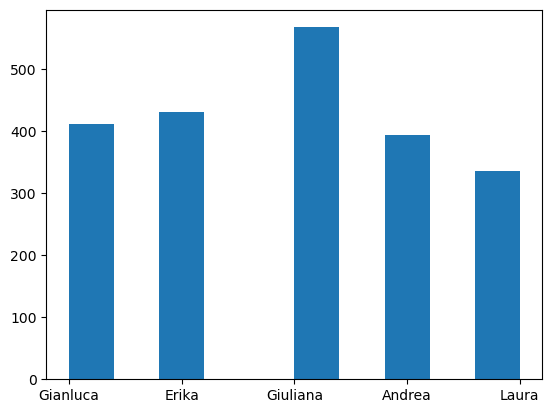

In [53]:
# we consider only numeric feature, these are the variables we are gonna use in the next analysis
X_train = train_data.drop(['Track', 'Artist', 'Tag'], axis=1)
y_true = train_data['Tag']
plt.hist(y_true)

We can see that more or less the data are well distributed among all the classes.

Now let's analyze the test set:

(array([1323.,    0.,  205.,    0.,    0., 1275.,    0.,   96.,    0.,
         152.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

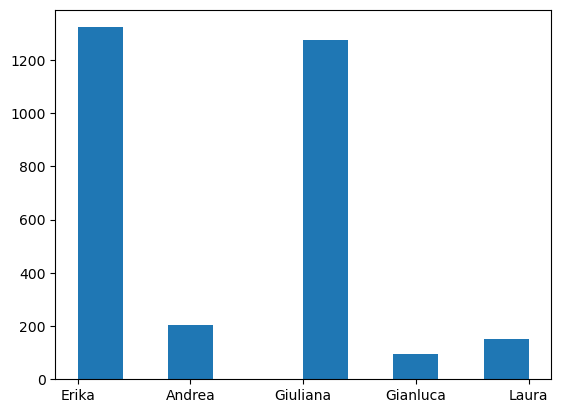

In [54]:
# variable we are going to use when working with unbalanced test set
X_test = test_data.drop(['Track', 'Artist', 'Tag'], axis=1)  # Exclude 'Track', 'Artist', and 'Tag' columns
y_test = test_data['Tag']

plt.hist(y_test)

It's obvious that the test set is heavily unbalanced because there are 2 classes that have more than 1200 entries while the other 3 have 200 or less entries. In order to conduct a proper analysis we have to rebalance the test set.

#### Balancing the Test Set

In [57]:
# BALANCING THE TEST SET
tag_count = y_test.value_counts()
test_resampled = pd.DataFrame(columns=test_data.columns)
min_count = round(tag_count.min())

for tag in tag_count.index:
    tags = test_data[test_data['Tag'] == tag]
    tag_resampled = resample(tags, replace=False, n_samples=min_count, random_state=42)
    test_resampled = pd.concat([test_resampled, tag_resampled])

# drop the useless features
# these are the variables we ar egoing to use when testing models on balanced test set.
X_test_bal = test_resampled.drop(['Track', 'Artist', 'Tag'], axis=1)
y_test_bal = test_resampled['Tag']

Let's take a look now:

(array([96.,  0., 96.,  0.,  0., 96.,  0., 96.,  0., 96.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

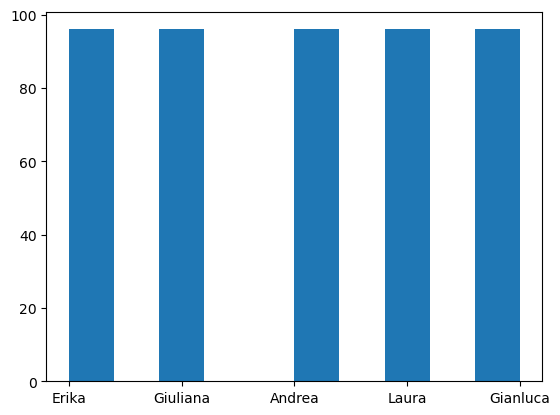

In [58]:
plt.hist(y_test_bal)

Now the classes are balanced and we can proceed with our analysis

### Briefly, what will we do later?

Our initial idea was to use clustering models in order to find group of songs because we assumed that by chosing 5 different music genres the songs will be divided in clusters. When we first presented the idea the teahcer suggested us to add labels and treat this as a supervised learning problem because otherwise we wouldn't have been able to assign each song to one of us. 

In order to properly perform this classification we chose many models and we will see which one works better. We chose 3 supervised learing models and one _half_ unsupervised learning (the _half_ will be more clear later). The model we've chosen are:
- Decision Tree (Sup. Learning);
- Random Forest (Sup. Learning);
- KNN (Sup. Learning);
- K-Means (Unsup. Learning).

We choose very different algorithms because each one of them has a different approaches to the classification, in fact a KNN or a K-Means algorithm work better with data divided into clusters and organized while the Decision Tree or especially the Random Forest work better with less organized and more random and overlapped data.

Since we noticed that the test set is heavily unbalanced we can perform our analysis with both test set and compare the results.

## Supervised Learning

### Decision Tree

Decision Tree is a supervised learning model that allows us to classify entries starting from a finite number of features. Each tree's node represent a feature of the dataset and for each feature we decide to split the dataset such that this split will give us, for example, the higher Information Gain - but could be used many others indicators.

In [59]:
# retrieve train set
X_train = train_data[features]
y_train = train_data['Tag']
# retrieve test set
X_test = test_data[features]
y_test = test_data['Tag']

# Create and train the model (example with Decision Tree)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

#### Predictions with the Unbalanced test set

Accuracy: 0.6597836774827925
Precision: 0.7607253017107414
Recall: 0.6597836774827925
F1-Score: 0.6904776516591181


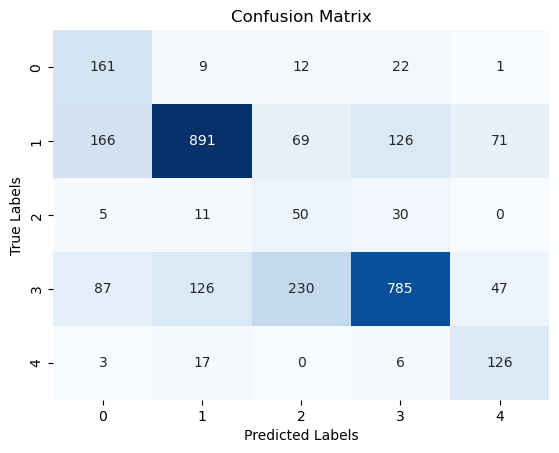

In [60]:
# Predict labels for the test dataset
test_predictions = model.predict(X_test)
test_data['predicted_Tag'] = test_predictions

accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions, average='weighted')
recall = recall_score(y_test, test_predictions, average='weighted')
f1 = f1_score(y_test, test_predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

cm = confusion_matrix(y_test, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Classes in the confusion matrix:**   
0 -> Andrea  
1 -> Erika  
2 -> Gianluca  
3 -> Giuliana  
4 -> Laura  

#### Prediction with Balanced test set

Accuracy: 0.7
Precision: 0.7094239603362159
Recall: 0.7
F1-Score: 0.7006017669320318


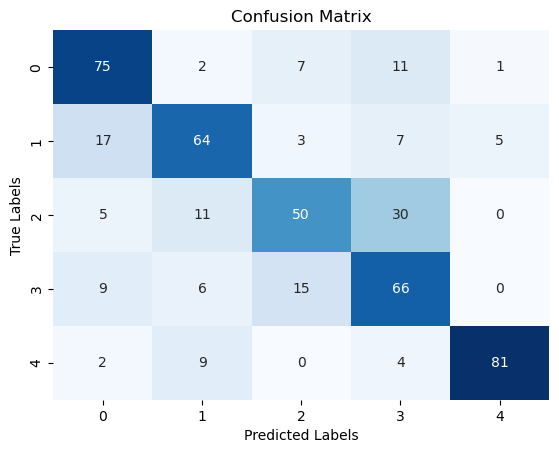

In [61]:
# Predict labels for the test dataset
test_predictions = model.predict(X_test_bal)
test_resampled['predicted_Tag'] = test_predictions

accuracy = accuracy_score(y_test_bal, test_predictions)
precision = precision_score(y_test_bal, test_predictions, average='weighted')
recall = recall_score(y_test_bal, test_predictions, average='weighted')
f1 = f1_score(y_test_bal, test_predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

cm = confusion_matrix(y_test_bal, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Comparison

We can see that as soon as we balanced the set, we gained some accuracy and some recall, but we lost some precision. Accuracy is an important metric when we are dealing with balanced test set, but it's not that reliable when dealing with unbalanced sets. By looking at the confusion matrix, we can see how when using the balanced set, the classes are overall well identified; notice that the model is facing issues when classifying entries from classes 2 (Gianluca) and 3  - it can be visualized because of a darker blu 2x2 matrix when classifying the two classes. 

Despite the balancing, if we look to the F1 score we can see that it hasn't changed that much, but if we look to Precision and Recall we can see that they are way more balanced - the improving Recall may indicates that the model is classifying better minority classes, while the decreasing Precision may indicates that the model makes more mistakes due to the balancing.

#### Create Playlist

To create the final plylist, we will start from the classification obtained from the balanced test set.

In [62]:
playlists_data = test_resampled[['Track','predicted_Tag']]
playlists_data = playlists_data.sort_values(['predicted_Tag', 'Track'])

# initialize an empty dataframe which will contains the top 20 songs
top_20 = pd.DataFrame()

# iterate over the tags, for each tag we are gonna add to the dataframe the first 20 songs
for tag in playlists_data['predicted_Tag'].unique():
    tag_playlist = playlists_data[playlists_data['predicted_Tag'] == tag].head(20)
    top_20 = pd.concat([top_20, tag_playlist])

# we don't need to display any features beyond the track name and the tag
top_20 = top_20[['Track', 'predicted_Tag']]
top_20.head()

,Track,predicted_Tag
1810,(It Goes Like) Nanana,Andrea
1042,APPLAUSE - TECHNO,Andrea
812,Akuma,Andrea
2723,All Fired Up,Andrea
3008,Atmosferic,Andrea


### Random Forest

Random Forest is an Ensemble learnign method for classification, which takes advantage of many Decision Trees.

In [63]:
# retrieve train set
X_train = train_data[features]
y_train = train_data['Tag']
# retrieve test set
X_test = test_data[features]
y_test = test_data['Tag']

# train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Predictions with unbalanced test set

Accuracy: 0.8036709275647329
Precision: 0.8485815050871336
Recall: 0.8036709275647329
F1-Score: 0.817479234063367


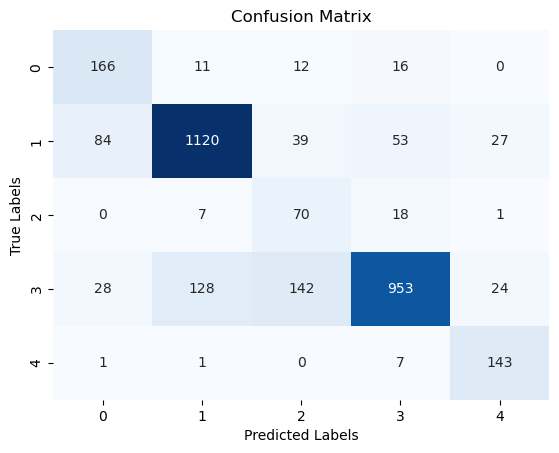

In [64]:
# Evaluate model performance on the validation set
y_pred = rf_model.predict(X_test)
test_data['predicted_Tag'] = y_pred

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Prediction with balanced test set

Accuracy: 0.8270833333333333
Precision: 0.8310505641092931
Recall: 0.8270833333333333
F1-Score: 0.8281796755240012


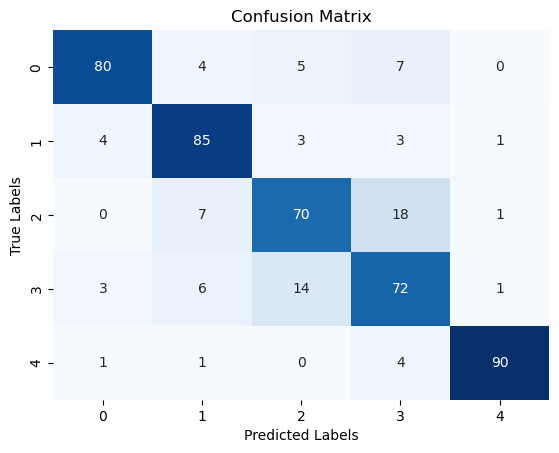

In [65]:
# Evaluate model performance on the validation set
y_pred = rf_model.predict(X_test_bal)
test_resampled['predicted_Tag'] = y_pred

precision = precision_score(y_test_bal, y_pred, average='weighted')
recall = recall_score(y_test_bal, y_pred, average='weighted')
f1 = f1_score(y_test_bal, y_pred, average='weighted')
accuracy = accuracy_score(y_test_bal, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

cm = confusion_matrix(y_test_bal, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Comparison

By a first lool to the results it doesn't seem like there are huge changes between the two predictions, but the second model overcomes the first in almost any metric (Precision excluded, but this always happens when rebalancing the test set). This model works better on the balanced set and allows us to have a very good performance despite the bad test set.   

When working on the balanced set we can see that also in this model there is a darker 2x2 around the classes 2 and 3, so this model is facing issues when it has to identify these two classes.

This result is reasonable because Random Forest is a good model when it comes to perform classification on dataset with data not well organized and not homogeneus.

#### Create the playlist

We will create the playlist starting from the predictions obtained from the unbalanced set.

In [66]:
playlists_data = test_data[['Track','predicted_Tag']]
playlists_data = playlists_data.sort_values(['predicted_Tag', 'Track'])

# initialize an empty dataframe which will contains the top 20 songs
top_20 = pd.DataFrame()

# iterate over the tags, for each tag we are gonna add to the dataframe the first 20 songs
for tag in playlists_data['predicted_Tag'].unique():
    tag_playlist = playlists_data[playlists_data['predicted_Tag'] == tag].head(20)
    top_20 = pd.concat([top_20, tag_playlist])

# we don't need to display any features beyond the track name and the tag
top_20 = top_20[['Track', 'predicted_Tag']]
top_20.head()

,Track,predicted_Tag
1810,(It Goes Like) Nanana,Andrea
475,A New Generation,Andrea
2319,ADESTE FIDELES,Andrea
1042,APPLAUSE - TECHNO,Andrea
642,Above The Clouds,Andrea


### KNN

Since we chose different music genres, we would expect that songs are well divided and organized in clusters, so we would expect good performance also from algorithms based on the neighborhoods of the points. Notice that the test set is unbalanced, hence I will perform the analysis with both balanced and unblanaced test set and later we will discuss the differences.

We have to find the best _k_ in order to apply our KNN algorithm, and we will do this with the GridSearch method: it is a hyperparameter tuning technique used to find the best combination of hyperparameter values for a machine learning model.

In [66]:
# choose some values (odd) for K over which we are gonna iterate in order to find the best k
k_values = [3, 5, 7, 9]

param_grid = {'n_neighbors': k_values}
# use gridsearch in order to find the best k

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# find the best k
best_k = grid_search.best_params_['n_neighbors']

# train model
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

Now that we have the best k and we trained it, we have to make our prediction on the test set. Since our dataset is unbalanced, first we will make our prediction with the unabalance dataset and later we will balance and see what changes.

#### Prediction with unbalanced test set

Then we make our predictions, always using our best k.

Accuracy: 0.3917
F1 Score: 0.4219


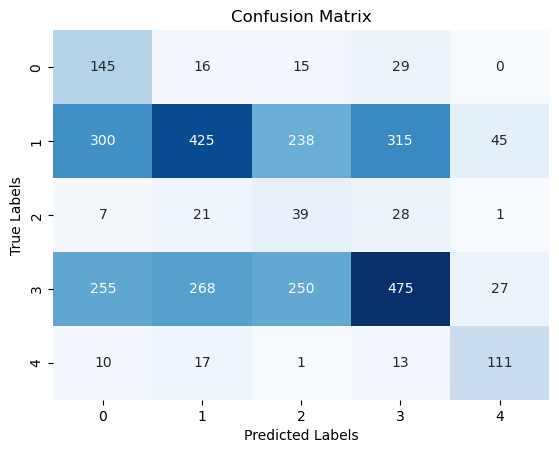

In [67]:
# test the model
y_pred = knn.predict(X_test)
# compute some useful metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Prediction with balanced test set

We make our predictions tooking advantage of the X_test_bal test set (balanced) we previously built in the pre-processing.

Accuracy: 0.5167
F1 Score: 0.5199


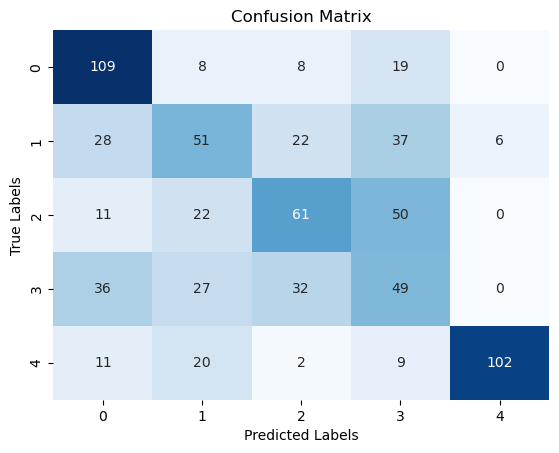

In [72]:
# test the model
y_pred_bal = knn.predict(X_test_bal)
# compute some useful metrics
accuracy = accuracy_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test_bal, y_pred_bal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Comparison

By looking at the results above, we can see how the accuracy increases as soon as we balance our test set, but not that much. From this low accuracy we can say that our data aren't organized in clusters and there are many overlapping between classes, hence the cassification by looking at the neighbours is not optimal.

When dealing with unbalanced data accuracy isn't a reliable metrics -as seen it decreased- but we can look the confusion matrix and the F1 score. In the confusion matric obtained from the umbalanced test set we can say that there are a lot of misinterpreted class - highilghted from a darker color - which is a consequence of the fact that those two classes are way more numerous than the other 3. Instead, by looking at the confusion matrix obtained from the balanced dataset, we can see how the darker colors are on the diagonal - it means that the algorithm can assign better the labels.

Moreover, it's obvious that also this algorithm has issues with the class 2 and 3, confirming the trend we had seen in the previous confusion matrixes.

#### Create playlist

Enstablished that the KNN works better with a Balance test set, we can know go on and build our playlists.

In [73]:
# add the columns with the predictions, this will be usefull later when we will create the playlists
test_resampled['predicted_Tag'] = y_pred_bal

playlists_data = test_resampled.drop_duplicates()
playlists_data = playlists_data.sort_values(['predicted_Tag', 'Track'])

# initialize an empty dataframe which will contains the top 20 songs
top_20 = pd.DataFrame()

# iterate over the tags, for each tag we are gonna add to the dataframe the first 20 songs
for tag in playlists_data['predicted_Tag'].unique():
    tag_playlist = playlists_data[playlists_data['predicted_Tag'] == tag].head(20)
    top_20 = pd.concat([top_20, tag_playlist])

# we don't need to display any features beyond the track name and the tag
top_20 = top_20[['Track', 'predicted_Tag']]
top_20.head()

,Track,predicted_Tag
962,"A Little Less Sixteen Candles, A Little More ""...",Andrea
2183,A Warm Welcome,Andrea
2319,ADESTE FIDELES,Andrea
1000,Abyss of Light,Andrea
2489,All I Ever Wanted (Techno),Andrea


## (Half-) Unsupervised Learning

We know that the K-Means is an unsupervised learning algorithm. In fact, we used the K-Means algorithm in order to group the songs in clusters, but later, given that we have to build some playlists (1 for each one of us) we needed some labels. Hence, we took advantage of the label we previously added and for each cluster we found the label with the higher count: given that label, we will assign that label to each song in that cluster. This is not a very good way to perform the classification - as we will show later - but it's the only way that allows us to create these playlist.

As a matter of fact, we called it _Half_ unsupervised because once we assign a cluster to each song (via K-Means) we assign a label to each cluster, making a true classification of the songs: in the end each song will be assigned to one of us, hence there will be a proper classification despite we started with an unsupervised earning algorithm.

### K-Means

To properly perform the clustering and the classification of the songs we have to find the best value for _k_ - which is the number of clusters. In order to do this, we chose a range of values for _k_ and through the **elbow method** -a graphical way- we found the best one.

With the **elbow method** we define a range of values for _k_ and then for each one we applied the K-Means algorithm. We saved both results in two arrays (**inertias** and **silhouette**). Now we will describe both.

### Inertia

represents the sum of squared distances between each data point in a cluster and the centroid of that cluster, hence it's a measure of the compactness of the clusters:

$I_i = \sum_{j=1}^{n_i} \lVert x_{ij} - \mu_i \rVert^2$


Where:
- $x_{ij}$ is the $j-th$ data point in cluster $C_i$, 
- $\mu_i$ is the centroid of cluster $C_i$,
- $\lVert \cdot \rVert^2$ denotes the squared Euclidean distance.

### Silhouette score
It's metric used to measure how well-defined the clustering. It provides a way to assess the quality of the clustering result by considering both the _cohesion_ within clusters and the _separation_ between clusters.

The silhouette score for a single data point i is defined as:
$s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$


Where:
- a(i) is the **cohesion**, or rather the average distance from the \(i\)-th data point to other points in the same cluster;
- b(i) is the **separation**, or better the average distance from the \(i\)-th data point to points in the nearest cluster.


We can define the Silhouette score for the entire dataset as follows:

$S = \frac{1}{N} \sum_{i=1}^{N} s(i)$

The silhouette score ranges from -1 to 1, the higher it is the better the algorithm is, in fact when we are looking for the best _k_ we want the value which maximizes this score:
- A score close to 1 indicates that the object is well matched to its own cluster;
- A score of 0 indicates that the object is very close to the decision boundary between two neighboring clusters;
- A score towards -1 indicates that the object might be better assigned to a neighboring cluster.
 


Givene these scores, if we follow the elbow method to find the best _k_ we have to find the value which maximizes the silhouette score and where the Inertia starts flattening.

Later, we will show how we implemented this revised K-Means algorithm

In [74]:
k_values = range(2, 20)  
# in order to find the best k we need to save for each k what score we do get
inertias = []
silhouette_scores = []

Then, we apply the K-Means model to each k from k_values and for each iteration we save the scores in the arrays previously initialized.

In [75]:
# iterate over the values for k
for k in k_values:
    # run the model and append the results
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))

Once done this, we can show the plot regarding the Silhouette score and the Inertia.

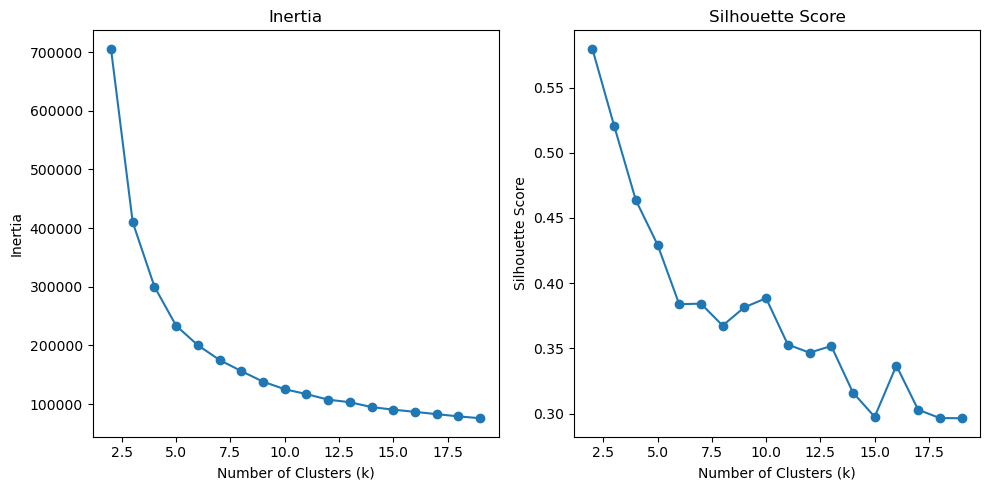

In [76]:
# below, we will show two plot regarding how 'inertia' and 'silhouette_scores' changes along with the k
plt.figure(figsize=(10, 5))

# intertia plot
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker='o')
plt.title('Inertia')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# silhouette plot
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In order to find the best K we analyze these plot, we are looking for the best trade off between Silhouette (high) and Inertia (low), therefore we will choose k=5. 

In [10]:
best_k = 5
best_kmeans = KMeans(n_clusters=best_k, random_state=42)
best_kmeans.fit(X_train)

KMeans(n_clusters=5, random_state=42)

After applied the K-Means to the best _k_, we find for each cluster the tag with the higher count, hence we created a dict that have as keys the cluster number and as values the tag. So, for each song, we change the cluster number with the tag, like a sort of classification - a weak one, as shown from the results.

In [8]:
# add cluster numbers
train['Cluster'] = best_kmeans.labels_
 # this dict will store for each cluster the tags with the higher counts
tags_dict = defaultdict(str)

# create dict that has as keys the cluster numbers and as values the tag with the highest count
for cluster in range(best_k):
    cluster_tags_count = train[train['Cluster'] == cluster]['Tag'].value_counts()
    most_present_tag = cluster_tags_count.idxmax()
    tags_dict[cluster] = most_present_tag

# we substitute for each cluster number the computed tag
train['predicted_Tag'] = train['Cluster'].map(tags_dict)

In the end, we compute the accuracy of our model and create the playlist.

In [9]:
playlists_data = train.drop_duplicates()
playlists_data = playlists_data.sort_values(['predicted_Tag', 'Track'])

# initialize an empty dataframe which will contains the top 20 songs
top_20 = pd.DataFrame()

# iterate over the tags, for each tag we are gonna add to the dataframe the first 20 songs
for tag in playlists_data['predicted_Tag'].unique():
    tag_playlist = playlists_data[playlists_data['predicted_Tag'] == tag].head(20)
    top_20 = pd.concat([top_20, tag_playlist])

# we don't need to display any features beyond the track name and the tag
top_20 = top_20[['Track', 'predicted_Tag']]

y_pred = train['predicted_Tag']
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3943


We know that both K-Means and KNN performs classification (unsupervised and supervised) based on the neighborhood of each point, hence it's clear that given their low results our dataframe is not good with clustering algorithm because apparently, despite we chose distinct music genres, there are many overlapping between data and there isn't any well defined cluster.

# Conclusion

In the end, this has become a multi-class classification problem instead of a clustering problem. By looking at the results and to the scores we are confident saying that our data are not suitable to clustering models and there aren't any well defined clusters and probably there are overlapping among the classes. In fact, the models based on the neighborhood of the points (KNN and K-Means) are not useful for our problems and don't perform well.

Moreover, when dealing with unbalanced test set, the Random Forest behave really well. As a matter of fact, the RF is a **ensemble learning** model that builds multiple decision trees and combines their predictions, making it more effective for unbalanced classes. In fact, this is the best model we could possibly found and it worked really well with both balanced and unbalanced test set.

Furthermore, by deploying the **confusion matrix** for each model we noticed that among the data there is a well identifiable tred, in particular each model has some issues and make several mistakes among class 2 (Gianluca) and 3 (Giuliana) of the confusion matrix -recognizable from a darker 2x2, which appear in almost any confusion matrix- and this is strenghtening our thesis that data are not well defined and separated.